### Deep Hedging


Payoff to hedge: $Z$

Wealth process with transaction cost:
$$
V_T = V_0 + (H\cdot S)_T - C_T.
$$
Given $V_0$, find the best strategy $H$ that minimize
$$
\mathbb{E}[\ell ((P-V_T)_+)]
$$
where $P$ is the payoff and $\ell(x) = \frac{x^{p}}{p},\quad p > 0$.

We numerically minimize the loss consisting of three terms
\begin{equation}
    \mathcal{L}(K) = \mathcal{L}_{p}(K) + \mathcal{L}_{\text{cost}}(K) + \mathcal{L}_{\text{ad}}(K),
\end{equation}
where 
\begin{equation*}
\begin{aligned}
    \mathcal{L}_{p}(K) &= \mathbb{E}\Big[\ell ((P-V_T)_+) \Big],\\
    \mathcal{L}_{\text{cost}}(K) &= c_{\text{cost}}\mathbb{E}\Big[\sum_{t=1}^{T-1}\lvert H_{t+1} - H_{t}\rvert \cdot S_{t}\Big],\\
    \mathcal{L}_{\text{ad}}(K) &= c_{\text{ad}}\mathbb{E}\Big[(-\min_{t}V_{t})_{+}\Big],
\end{aligned}
\end{equation*}

In [1]:
import numpy as np
import torch

from math import ceil
import matplotlib.pyplot as plt

from neuralhedge.nn import datahedger, contigent, mlp, loss
from neuralhedge.nn.loss import ExpectedShortfall
from neuralhedge.market import stochastic, markets
from neuralhedge._utils.plotting import plot_pnl, plot_history, plot_data_set, plot_hedge
from importlib import reload


Shape of paths:  torch.Size([50000, 31, 1])
Shape of information:  torch.Size([50000, 31, 2])
Shape of payoff:  torch.Size([50000, 31, 1])


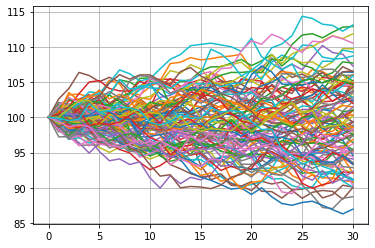

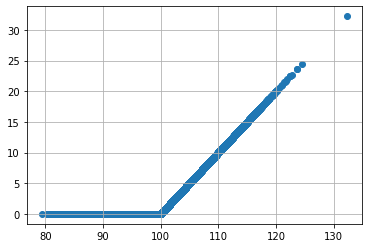

True price is:  tensor(2.2511)


In [2]:
data_set, dataset_market = markets.BlackScholesTestMarket()
paths, information, payoff = data_set
n_asset = paths.shape[-1]
plot_data_set(data_set)
print('True price is: ', payoff[:,-1].mean())

/opt/homebrew/Caskroom/miniforge/base/envs/NeuralHedge/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Loss=0.5310617685317993: 100%|██████████| 100/100 [02:49<00:00,  1.70s/it]


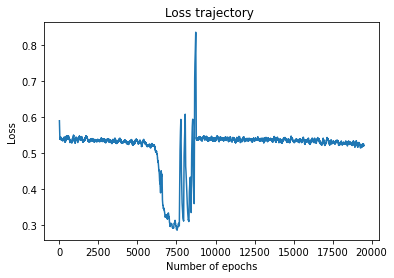

In [3]:
from typing import List
from typing import Optional

from torch import Tensor
from torch.nn import Module
from neuralhedge.nn.loss import admissible_cost

price = 2.0
class EfficientHedger(datahedger.Hedger):
    def __init__(self,model: Optional[Module]):
        super().__init__(model)
    def compute_pnl(self, input: List[Tensor]):
        prices, information, payoff = input
        wealth= self(input)
        pnl = wealth - payoff + price
        return pnl
    def compute_loss(self, input: List[Tensor]):
        prices, information, payoff = input
        wealth= self(input)
        pnl = wealth - payoff + price
        ad_cost = admissible_cost(wealth)
        loss = self.criterion(pnl) + 0.01 * ad_cost
        return loss
        # TODO: make it clean here



model = mlp.NeuralNetSequential(n_output = n_asset)
hedger = datahedger.Hedger(model) 
# history = hedger.fit(dataset_market, EPOCHS=0,criterion=loss.PowerMeasure(10)) 

Loss=0.31084680557250977: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


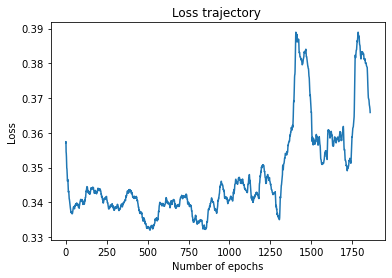

In [10]:
history = hedger.fit(dataset_market, EPOCHS=10,criterion=loss.PowerMeasure(10)) 
plot_history(history)

Price:  2.0


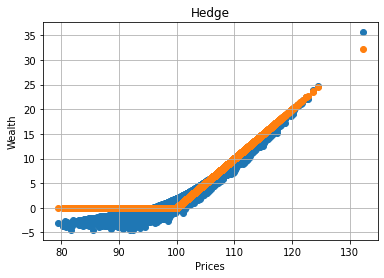

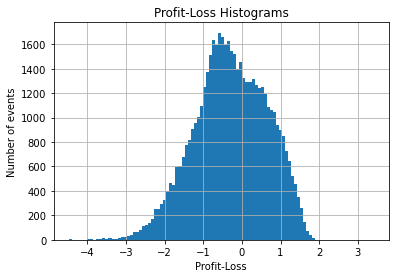

In [12]:
plot_hedge(hedger, data_set, price = price)

In [13]:
wealth = hedger(data_set)
admissible_cost(wealth)

tensor(2.0391, grad_fn=<MeanBackward0>)